# Visualising UNET #

### Abstract ###

- Self explained. Using `torch_view` as main library.
- The docuement below is mainly copied from [mega_cmp.ipynb](./v2a/mmega_cmp.ipynb)

### Required libraries ###

- ~~Should be the common ML pack we're using. Also with [SD webui's dependency](https://github.com/AUTOMATIC1111/stable-diffusion-webui).~~

- [torchview](https://torchview.dev/)
- [scikit-learn](https://scikit-learn.org/stable/install.html)
- [NetworkX](https://networkx.org/documentation/stable/release/release_3.0.html)
- [safetensors](https://huggingface.co/docs/safetensors/index)
- [diffusers](https://huggingface.co/docs/diffusers/installation)
- [omegaconf](https://anaconda.org/conda-forge/omegaconf)
- [pytorch](https://pytorch.org/get-started/locally/#windows-python)
- [matplotlib](https://matplotlib.org/stable/api/matplotlib_configuration_api.html)
- [numpy](https://numpy.org/)
- [torchinfo](https://pypi.org/project/torchinfo/)

### Some layer name to interprept (for SD1.5) ###
- `first_stage_model`: VAE
- `cond_stage_model`: Text Encoder
- `model.diffusion_model`: Diffusion model
- `model_ema`: EMA model for training
- `cumprod`, `betas`, `alphas`: `CosineAnnealingLR`

### Some notation (Useful in the bin chart) ###
- `attn1`: `sattn` = *Self attention*
- `attn2`: `xattn` = *Cross attention*
- `ff`: *Feed forward*
- `norm`: [Normalisation layer](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html). `elementwise_affine=True` introduces trainable `bias` and `weight`. 
- `proj`: *Projection*
- `emb_layers`: *Embedding layers*
- `others`: `ff` + `norm` + `proj` + `emb_layers`

## Importing libraries ##

In [1]:
import os
import torch
from safetensors.torch import load_file #safe_open
from diffusers import UNet2DConditionModel

from torchview import draw_graph
from torchinfo import summary

import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
# Fix for OMP: Error #15
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
# TODO: Support 'cuda', but 'cpu' is arleady fast.
g_device = "cuda:0" #"cpu"
# Currently for generating graph only.
g_seed = 114514

In [5]:
# Model path
model_path = {
    "sd1": "runwayml/stable-diffusion-v1-5",
    "sd2": "stabilityai/stable-diffusion-2-1",
    "sdxl": "stabilityai/stable-diffusion-xl-base-1.0"
}

model_type = torch.float16 if "cuda" in g_device else torch.float # CPU doesn't support FP16 / FP8


Only online model is available.

`load_single_file` is failed (versioning hell, omitted). I load online model instead.

In [6]:
unet_instance = None # Clear
unet_instance = {} # Clear

In [7]:
# We run it later
# for k in model_path.keys():
#    unet_instance[k] = UNet2DConditionModel.from_pretrained(model_path[k], subfolder="unet",  torch_dtype=torch.float16).to(g_device)

Input size is trial and error.

Not actually, we can read `config.json` form the actual official model in HuggingFace, and `nn.Module` has already created with the config. 

Originally it is scattered in different Git Repos, but HF does a great job here.

- `sd1`: [stabilityai/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5/blob/main/unet/config.json)
- `sd2`: [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1/blob/main/unet/config.json)
- `sdxl`: [stabilityai/stable-diffusion-xl-base-1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/unet/config.json)

In [8]:
# Not Used.
input_data_mapping_sample = {
    "sd1": {
        'sample': torch.rand(1, 4, 64, 64, dtype=model_type).to(g_device),
        'timestep': torch.rand(1, dtype=model_type).to(g_device),
        'encoder_hidden_states': torch.rand(1, 77, 768, dtype=model_type).to(g_device),
    },
    "sd2": {
        'sample': torch.rand(1, 4, 96, 96, dtype=model_type).to(g_device),
        'timestep': torch.rand(1, dtype=model_type).to(g_device),
        'encoder_hidden_states': torch.rand(1280, 77, 1024, dtype=model_type).to(g_device),
    },
    "sdxl": {
        'sample': torch.rand(1, 4, 128, 128, dtype=model_type).to(g_device),
        'timestep': torch.rand(1, dtype=model_type).to(g_device),
        'encoder_hidden_states': torch.rand(1280, 77, 2048, dtype=model_type).to(g_device),
        'added_cond_kwargs': {
            'text_embeds': torch.rand(1280, 2560, dtype=model_type).to(g_device),
            'time_ids': torch.rand(1280, dtype=model_type).to(g_device),
        },
    },
}

Setting Graph output.

In [9]:
filename_paths = {
    "sd1": "./sd1_unet",
    "sd2": "./sd2_unet",
    "sdxl": "./sdxl_unet",
}

In [10]:
# For in place generation (requested)
png_results = {}

Main loop. Note that `input_data` is generated inplace. The expected dimension is already available in `model.config` mentioned above.

Notice that we keep `depth=1` since we are desperate to **link MBW layers** instead of study how the UNET layers work (there are plenty of guide).

Also it keep the diagram elegent (however the count won't match!)

In [11]:
def main_loop(cur_unet):
    unet_instance[cur_unet] = UNet2DConditionModel.from_pretrained(model_path[cur_unet], subfolder="unet",  torch_dtype=model_type).to(g_device) if cur_unet not in unet_instance else unet_instance[cur_unet]

    channel = unet_instance[cur_unet].config.in_channels
    sequence_length = 77 # See CLIPTextModel.max_position_embeddings
    feature_dim = unet_instance[cur_unet].config.cross_attention_dim # Should fit CLIPTextModel.hidden_size, 2048 = 768 + 1280 for SDXL
    height = unet_instance[cur_unet].config.sample_size
    width = height #square is fine
    step = 1 #arbitary single float
    batch = 1 #1bs

    inplace_input_data = {
        'sample': torch.rand(batch, channel, height, width, dtype=model_type).to(g_device),
        'timestep': torch.rand(step, dtype=model_type).to(g_device),
        'encoder_hidden_states': torch.rand(batch, sequence_length, feature_dim, dtype=model_type).to(g_device),
    }

    # SDXL special
    if cur_unet == "sdxl":
        addition_time_embed_dim = unet_instance[cur_unet].config.addition_time_embed_dim
        projection_class_embeddings_input_dim = unet_instance[cur_unet].config.projection_class_embeddings_input_dim
        time_sequence_length = projection_class_embeddings_input_dim - addition_time_embed_dim
        inplace_input_data['added_cond_kwargs'] = {
            'text_embeds': torch.rand(batch, time_sequence_length, dtype=model_type).to(g_device),
            'time_ids': torch.rand(batch, dtype=model_type).to(g_device),
        }

    model_summary = summary(unet_instance[cur_unet], 
        input_data=inplace_input_data, 
        col_names=("input_size", "output_size", "num_params")
    )

    with open(filename_paths[cur_unet] + '.txt', 'w') as the_file:
        the_file.write(str(model_summary))

    unet_png = draw_graph(unet_instance[cur_unet], 
        input_data=inplace_input_data, 
        graph_name=model_path[cur_unet], 
        device=g_device, mode="eval", 
        depth=1,       
        roll=True,        
        save_graph=True,
        filename=filename_paths[cur_unet]
    ) #, expand_nested=True, hide_inner_tensors=False, 

    png_results[cur_unet] = unet_png

- `sd1`: Should run with no problem
- `sd2`: May OOM, however I'm using RTX 3090 now.
- `sdxl`: This is tricky: No docuement. [Read code](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py) for workaround.

In [12]:
for k in filename_paths:
    main_loop(k)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.

(process:17136): Pango-WARNING **: 08:05:05.167: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.

(process:3480): Pango-WARNING **: 08:05:17.470: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.
Cannot initialize model with low cpu memory usage because `accelerate` was 

Now generate the image inplace.


(process:25400): Pango-WARNING **: 08:05:49.441: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


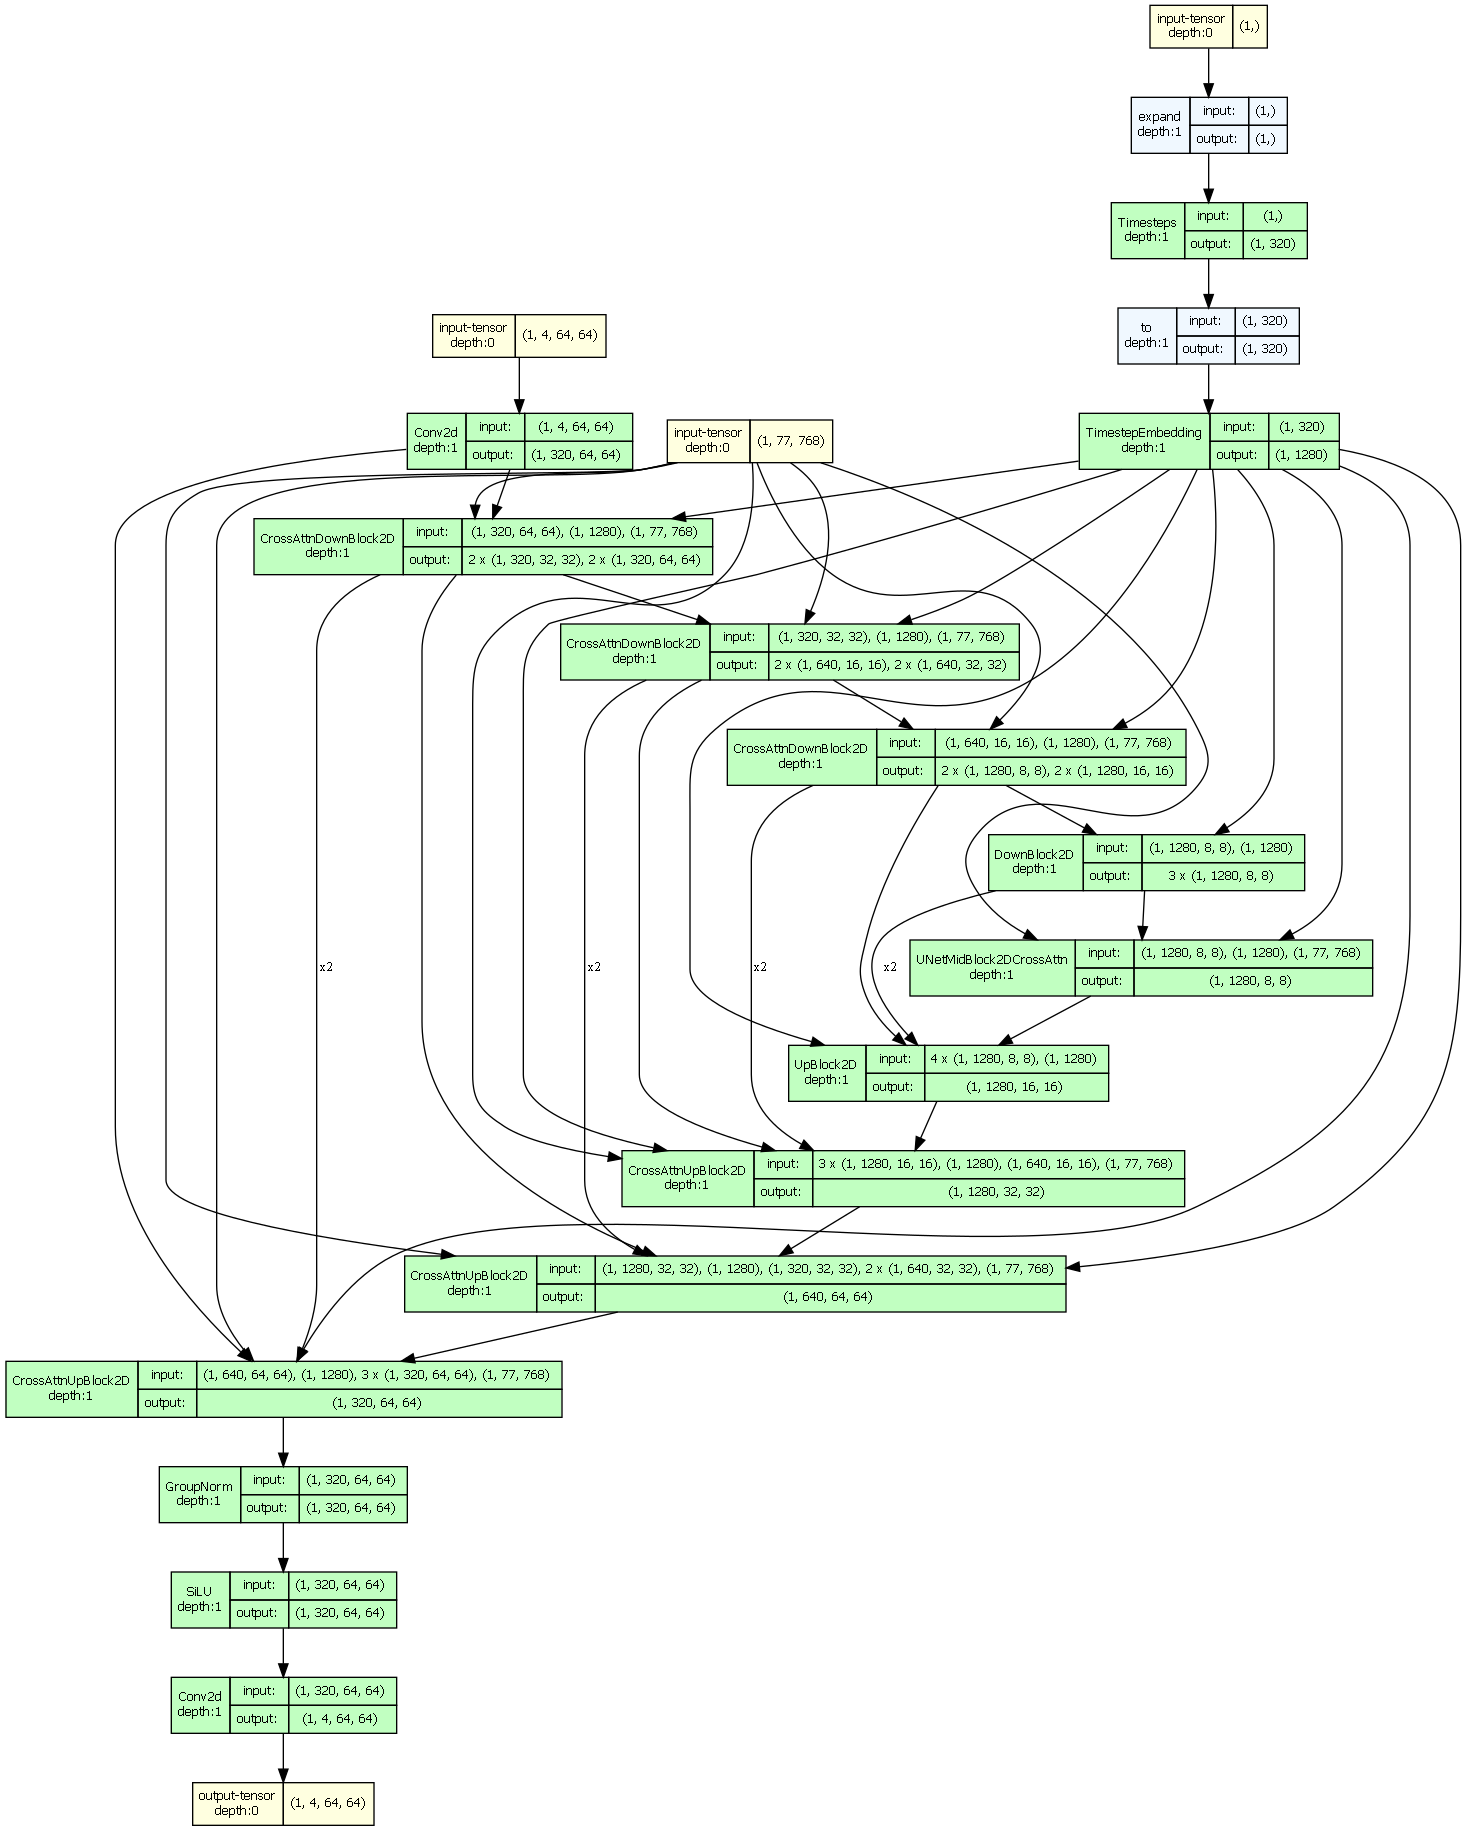

In [13]:
png_results["sd1"] .visual_graph


(process:36748): Pango-WARNING **: 08:05:49.924: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


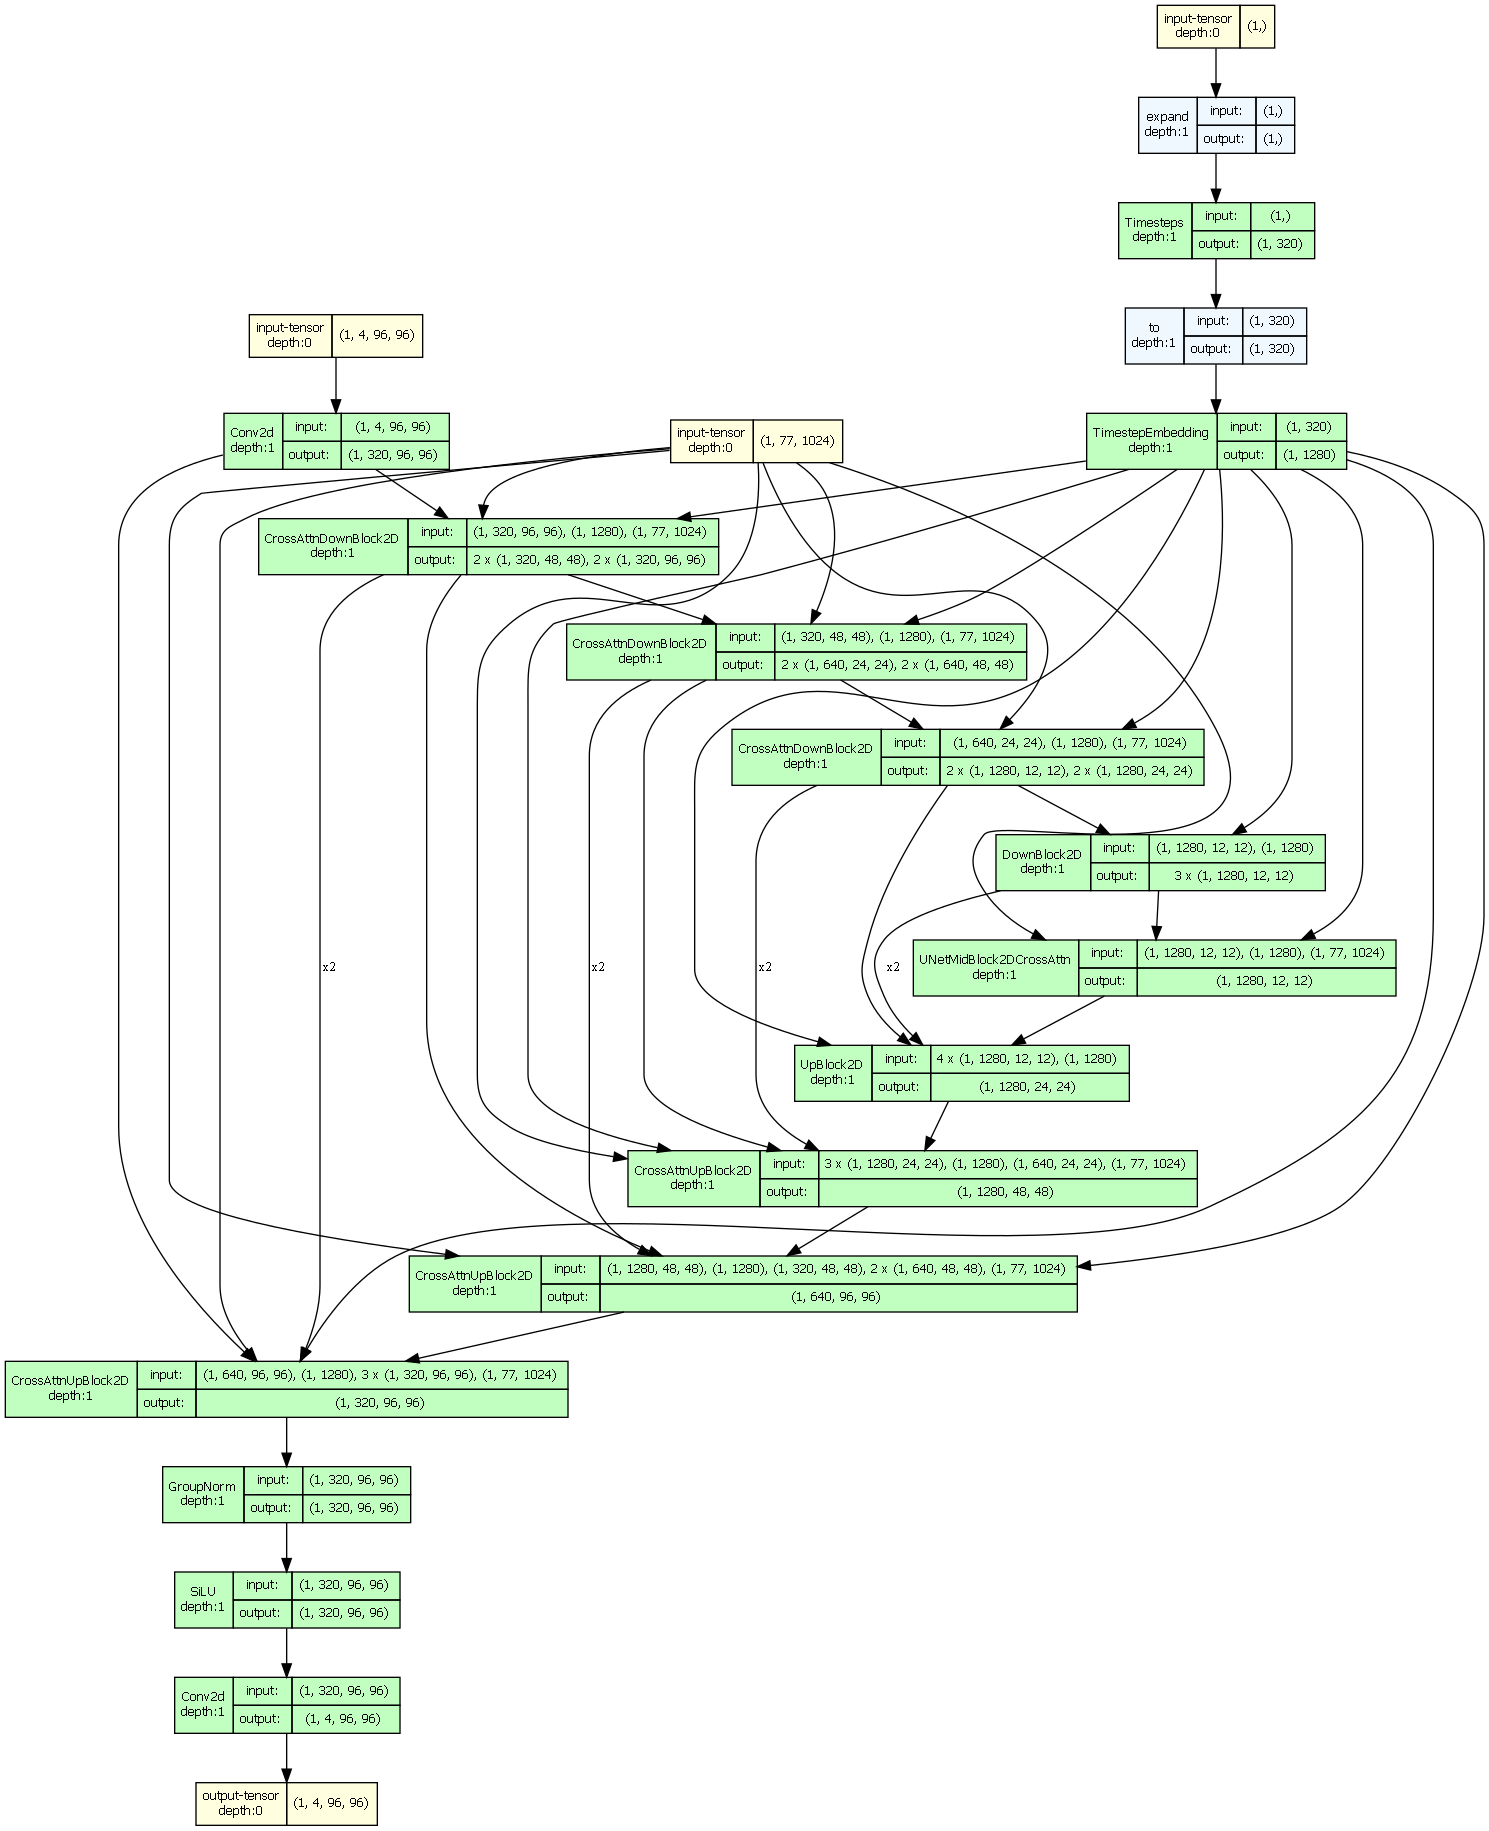

In [14]:
png_results["sd2"] .visual_graph


(process:36428): Pango-WARNING **: 08:05:50.409: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


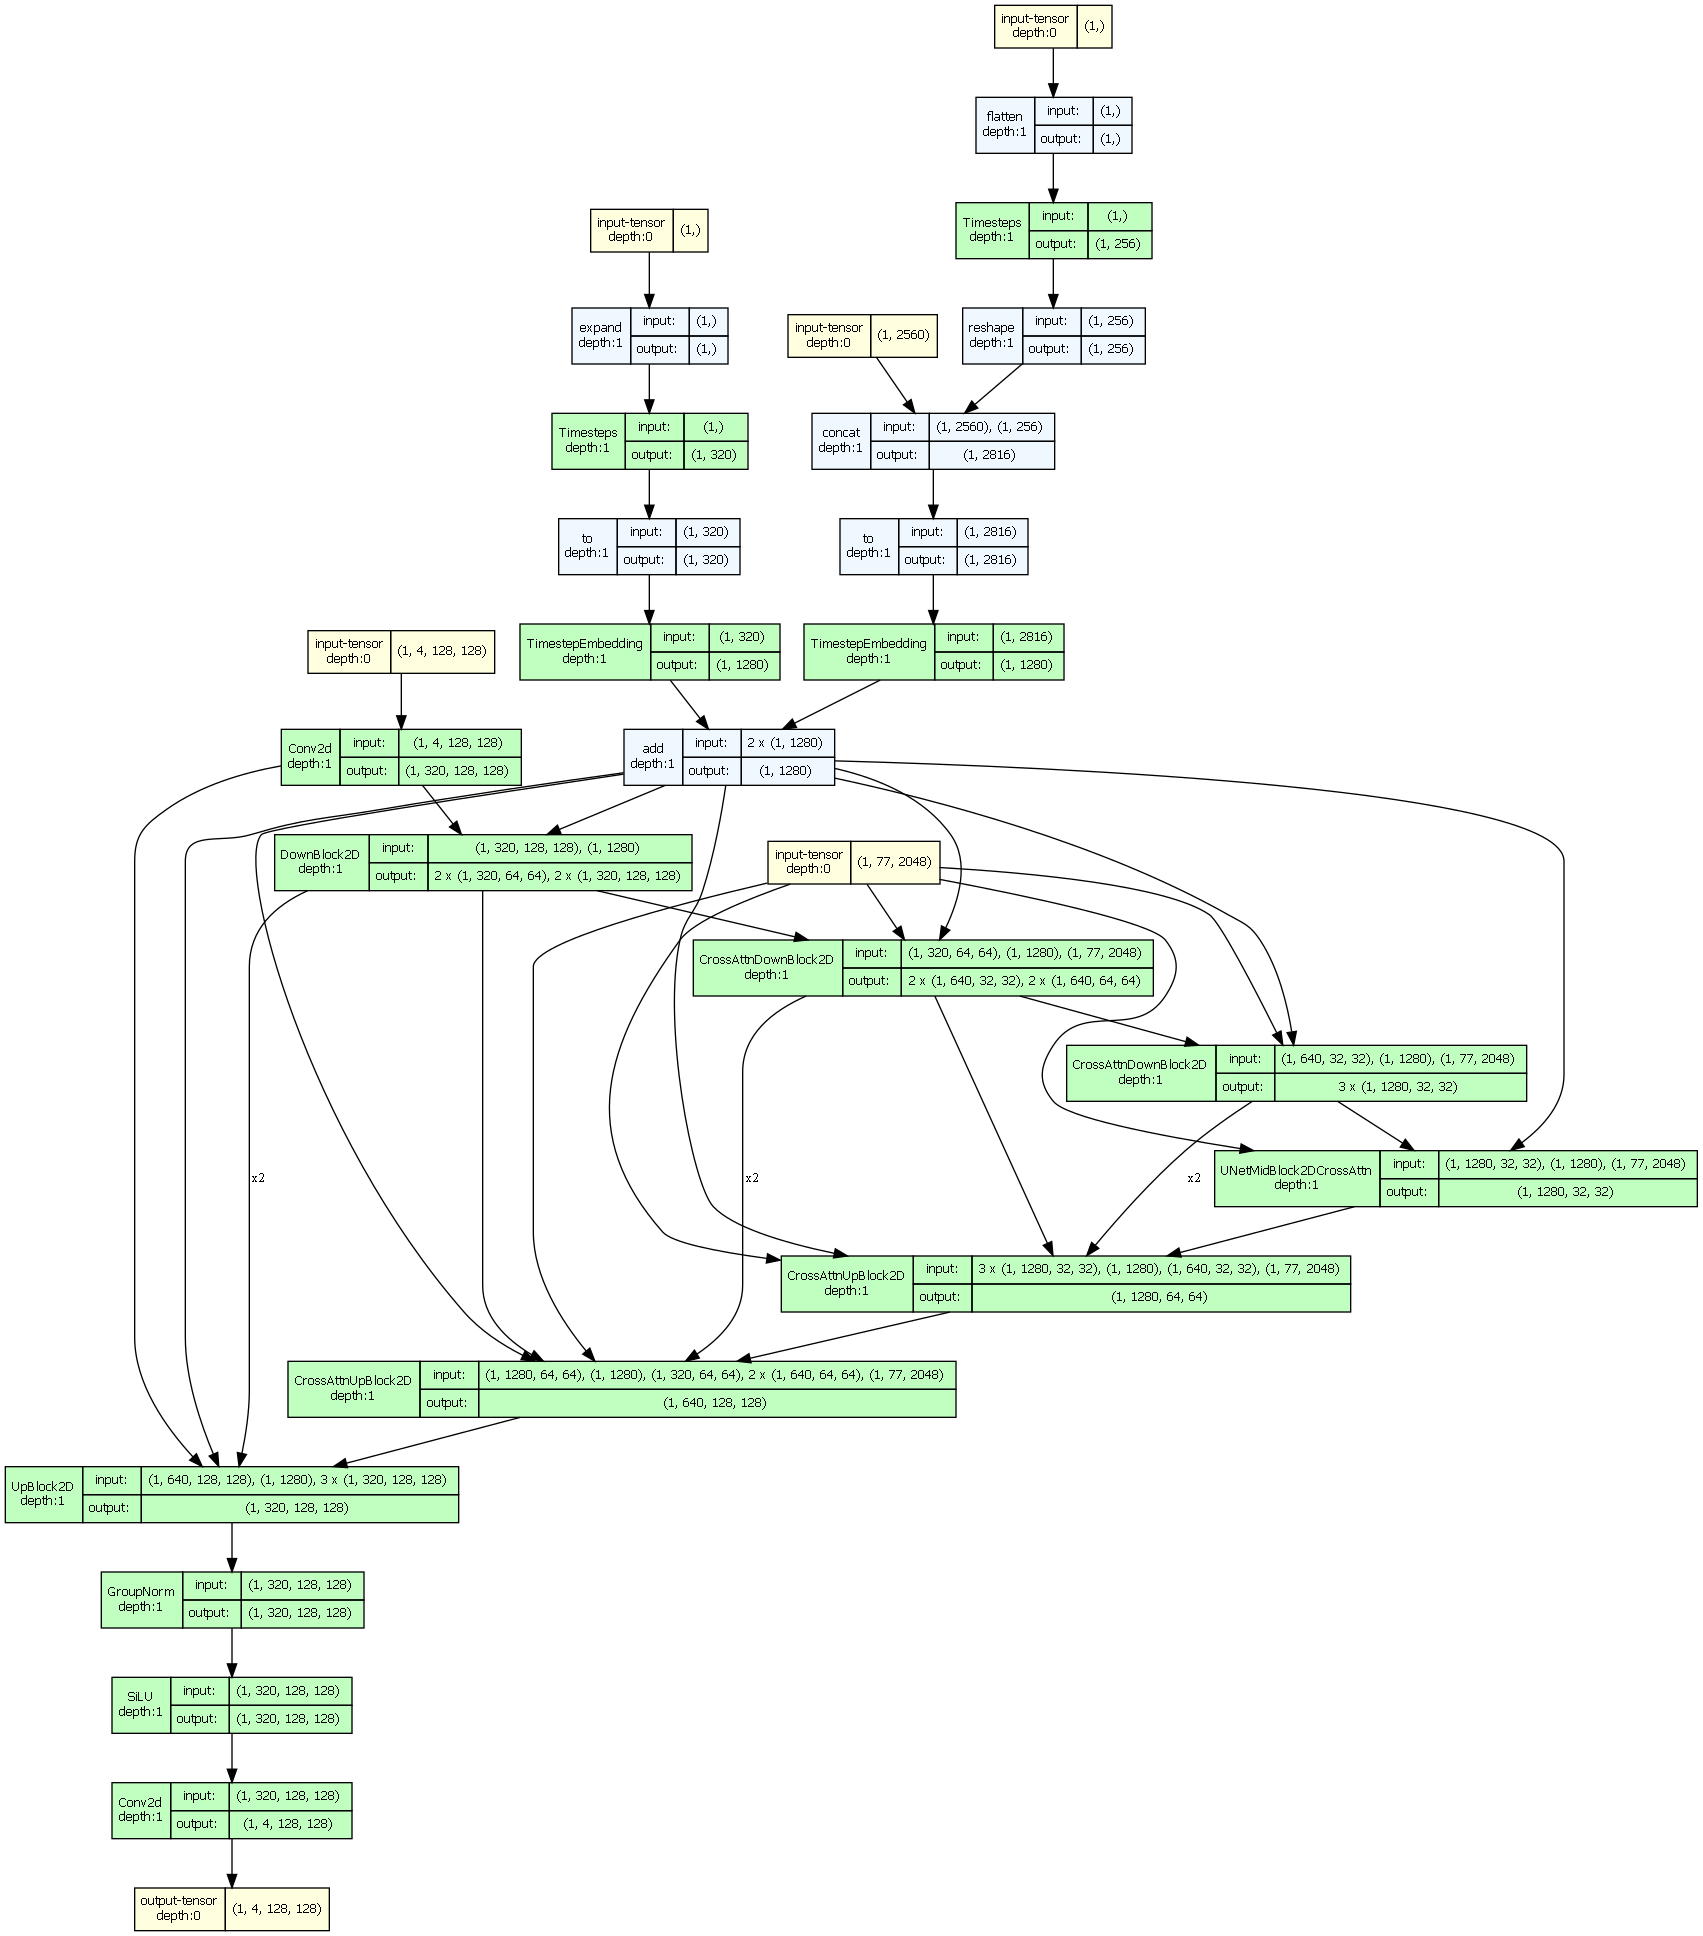

In [15]:
png_results["sdxl"] .visual_graph

Now all diagrams and summaries are generated. Now we can try to map MBW layers (`IN00-11`, `MID`, `OUT00-11`) to the diagram.

In [16]:
local_model_path = "../../stable-diffusion-webui/tmp/view_unet/21b-AstolfoMix-2020b.safetensors"
local_model = load_file(local_model_path, device=g_device)

`load_file` only return a HUGE `dict`. You can use JSON library to visualize it, but it is not useful. There is no linkage between the layers.

First, make a nice name finder.

In [17]:
def do_a_keyword_in_a_layer(layer, *keywords):
    for k in keywords:
         if k not in layer:
            return False
    return True

def do_some_keywords_in_some_layers(model, *keywords):
    for layer in list(model.keys()):
        if do_a_keyword_in_a_layer(layer, *keywords):
            return layer
    return False

Now we read the summary and the png, there are some noticeable layers: 

|Layer Name|IN / MID / OUT?|Presence of Transformer Layers?|
|---|---|---|
|`CrossAttnDownBlock2D`|`input_blocks`|`transformer_blocks`| 
|`DownBlock2D`|`input_blocks`|n/a|
|`UNetMidBlock2DCrossAttn`|`middle_block`|`transformer_blocks`|
|`UpBlock2D`|`output_blocks`|n/a|
|`CrossAttnUpBlock2D`|`output_blocks`|`transformer_blocks`|

In [18]:
block_layers = ['input_blocks', 'middle_block', 'output_blocks']
layers_count = 12

for b_l in block_layers:
    for i in range(layers_count):
        serarch_result = do_some_keywords_in_some_layers(local_model, "{}.{}.".format(b_l, i), "transformer_blocks")
        if serarch_result:
            print(serarch_result)

model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight
model.diffusion_model.output_blocks.8.1.transformer_blocks.0.